In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import backend as K
import tensorflow as tf

#from tensorflow.keras.regularizers import l1

In [3]:
import pickle

In [4]:
def calculate_smape(actual, predicted) -> float: 
  
    # Convert actual and predicted to numpy 
    # array data type if not already 
    if not all([isinstance(actual, np.ndarray), isinstance(predicted, np.ndarray)]): 
        actual, predicted = np.array(actual), np.array(predicted) 
  
    return round( 
        np.mean( np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2) )*100, 2
    ) 

Reading the pickle file with the object that has the normalized data and the scalers.

In [5]:
file_to_read = open("preprocessed_data.pickle", "rb")

pipe = pickle.load(file_to_read)

file_to_read.close()

Fitting a LSTM network to each oil basin time series and evaluating the adjustment 

Reading the pickle file with the object that has the normalized data and the scalers.

In [6]:
lag = 10
resultados = {
    'campo':[] ,
    'idx_treino':[] ,
    'idx_teste': [] ,
    'preds': [] ,
    'y_test':[]
}

for campo in pipe.keys():

    X_treino = pipe[campo][0][10:,np.array(range(9,-1,-1))]
    y_treino = pipe[campo][0][10:,-1]

    K.clear_session()

    #tss = TimeSeriesSplit(n_splits = (int)(X_treino.shape[0] * 0.2), test_size = 1)

    idx_train = range( 0,int(X_treino.shape[0] * 0.8) )
    idx_test = range( int(X_treino.shape[0] * 0.8) , X_treino.shape[0])

    #for idx_train, idx_test in tss.split(X_treino):
    X_train = X_treino[idx_train].reshape(-1,10,1)
    y_train = y_treino[idx_train].reshape(-1,1,1)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=12, activation='relu', input_shape=(lag, 1)))
    #model.add(LSTM(units=50, activation='relu'))
    model.add(Dense(units=1))
    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)

    X_test = X_treino[idx_test].reshape(-1,10,1)
    y_test = y_treino[idx_test].reshape(-1,1,1)

    predictions = model.predict(X_test)

    resultados['campo'].append(campo)
    resultados['idx_treino'].append( idx_train )
    resultados['idx_teste'].append( idx_test )
    resultados['preds'].append( predictions.reshape(-1) )
    resultados['y_test'].append( y_test.reshape(-1) )

    print(f"Campo: {campo} finalizado!" )


2/2 [==============================] - 0s 8ms/step
Campo: TUPI finalizado!
1/1 [==============================] - 0s 149ms/step
Campo: BAÚNA finalizado!
1/1 [==============================] - 0s 136ms/step
Campo: URUGUÁ finalizado!
1/1 [==============================] - 0s 128ms/step
Campo: SAPINHOÁ finalizado!
1/1 [==============================] - 0s 185ms/step
Campo: MEXILHÃO finalizado!
1/1 [==============================] - 0s 132ms/step
Campo: LAPA finalizado!
1/1 [==============================] - 0s 160ms/step
Campo: TAMBAÚ finalizado!
1/1 [==============================] - 0s 128ms/step
Campo: BÚZIOS finalizado!
1/1 [==============================] - 0s 125ms/step
Campo: SÉPIA finalizado!
1/1 [==============================] - 0s 293ms/step
Campo: BERBIGÃO finalizado!
1/1 [==============================] - 0s 124ms/step
Campo: ITAPU finalizado!
1/1 [==============================] - 0s 124ms/step
Campo: ATAPU finalizado!
1/1 [==============================] - 0s 96ms/step
Camp

In [7]:
resultados_lstm_individual = pd.DataFrame(resultados)

In [8]:
real = np.array([])
predicted = np.array([])
for i in range(0,20):
    real = np.append(real, resultados['y_test'][i][0])
    predicted = np.append(predicted, resultados['preds'][i][0])
print(f"RMSE: {mean_squared_error(real , predicted, squared = False)}")
print(f"MAE: {mean_absolute_error(real, predicted)}" )
print(f"MSE: {mean_squared_error(real , predicted)}")

RMSE: 0.21294746737258696
MAE: 0.15847105571774783
MSE: 0.04534662386039899


In [9]:
resultados_lstm_individual['mse'] = [ mean_squared_error(i[1]['y_test'], i[1]['preds']) for i in resultados_lstm_individual.iterrows()]
resultados_lstm_individual['rmse'] = [ mean_squared_error(i[1]['y_test'], i[1]['preds'],squared=False) for i in resultados_lstm_individual.iterrows()]
resultados_lstm_individual['mae'] = [ mean_absolute_error(i[1]['y_test'], i[1]['preds']) for i in resultados_lstm_individual.iterrows()]

resultados_lstm_individual['mse_1'] = [ mean_squared_error([i[1]['y_test'][0]], [i[1]['preds'][0]]) for i in resultados_lstm_individual.iterrows()]
resultados_lstm_individual['rmse_1'] = [ mean_squared_error([i[1]['y_test'][0]], [i[1]['preds'][0]],squared=False) for i in resultados_lstm_individual.iterrows()]
resultados_lstm_individual['mae_1'] = [ mean_absolute_error([i[1]['y_test'][0]], [i[1]['preds'][0]]) for i in resultados_lstm_individual.iterrows()]

In [10]:
resultados_lstm_individual 

,campo,idx_treino,idx_teste,preds,y_test,mse,rmse,mae,mse_1,rmse_1,mae_1
0,TUPI,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(128, 129, 130, 131, 132, 133, 134, 135, 136, ...","[0.915099, 0.8969966, 0.87306046, 0.881499, 0....","[0.8214066534253689, 0.7647913774854848, 0.865...",0.004540,0.067381,0.051094,0.008778,0.093692,0.093692
1,BAÚNA,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(120, 121, 122, 123, 124, 125, 126, 127, 128, ...","[0.22501653, 0.23034155, 0.21733344, 0.2287899...","[0.1975508185171136, 0.10235965707566395, 0.19...",0.012736,0.112854,0.095477,0.000754,0.027466,0.027466
2,URUGUÁ,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(116, 117, 118, 119, 120, 121, 122, 123, 124, ...","[0.11669578, 0.22213143, 0.17650187, 0.1895125...","[0.3589638811011853, 0.12684957803800515, 0.19...",0.012123,0.110106,0.086205,0.058694,0.242268,0.242268
3,SAPINHOÁ,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(100, 101, 102, 103, 104, 105, 106, 107, 108, ...","[0.73952484, 0.7467226, 0.74751014, 0.7584889,...","[0.7584455110898232, 0.7374497783545088, 0.778...",0.006304,0.079400,0.053440,0.000358,0.018921,0.018921
4,MEXILHÃO,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(109, 110, 111, 112, 113, 114, 115, 116, 117, ...","[0.46657106, 0.45715952, 0.44769305, 0.4512591...","[0.44390206904052504, 0.432519340906554, 0.489...",0.010820,0.104019,0.062669,0.000514,0.022669,0.022669
5,LAPA,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 8...","[0.8624576, 0.8831786, 0.8515013, 0.8800314, 0...","[0.9655466459597909, 0.8651958259139064, 0.947...",0.021319,0.146012,0.096212,0.010627,0.103089,0.103089
6,TAMBAÚ,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(97, 98, 99, 100, 101, 102, 103, 104, 105, 106...","[0.04130502, 0.04130502, 0.04130502, 0.0413050...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.001569,0.039613,0.039035,0.001706,0.041305,0.041305
7,BÚZIOS,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 9...","[0.87828255, 0.69261193, 0.5703118, 0.49172893...","[0.23425834000279713, 0.19933104240630184, 0.2...",0.065306,0.255550,0.227114,0.414767,0.644024,0.644024
8,SÉPIA,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9...","[0.15735416, 0.20199169, 0.19604857, 0.1851363...","[0.39721008887005116, 0.3247225642260197, 0.35...",0.179242,0.423369,0.384828,0.057531,0.239856,0.239856
9,BERBIGÃO,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9...","[0.3602188, 0.37486094, 0.32729077, 0.4062037,...","[0.4721462905503638, 0.3657926517014161, 0.581...",0.036034,0.189826,0.151524,0.012528,0.111927,0.111927


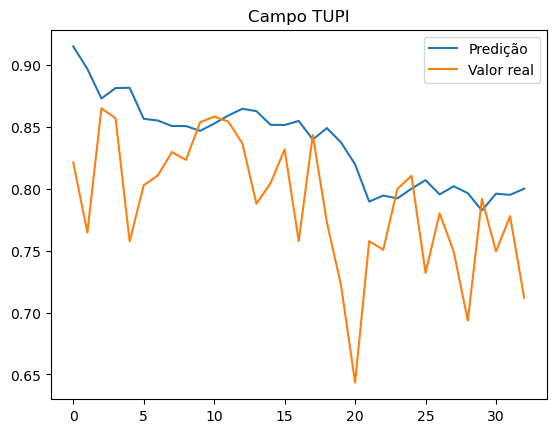

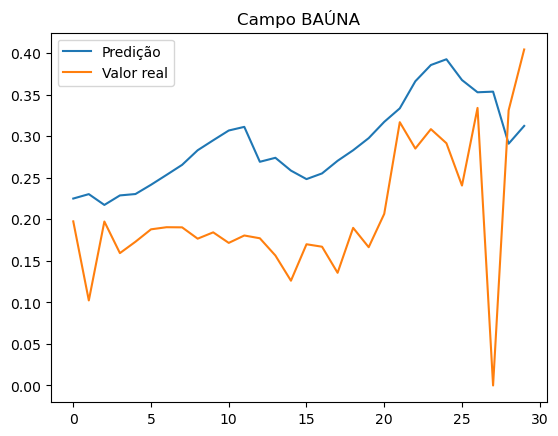

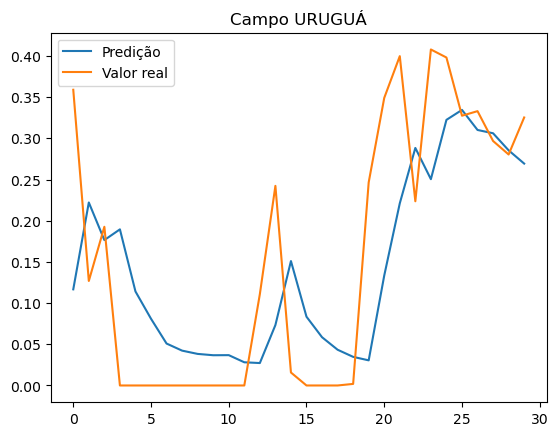

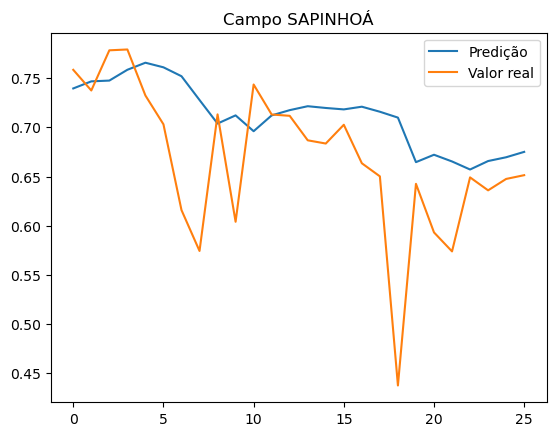

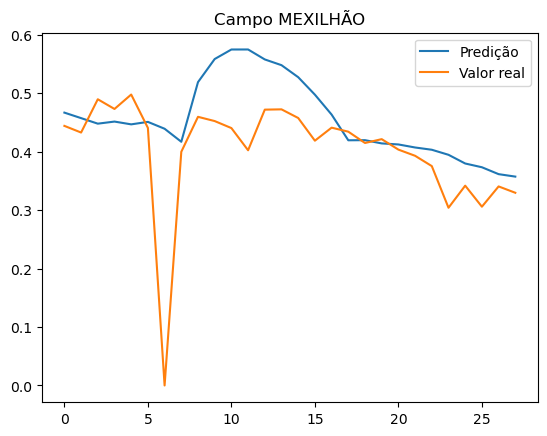

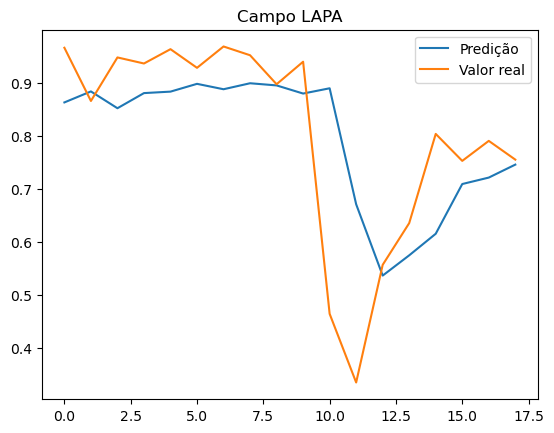

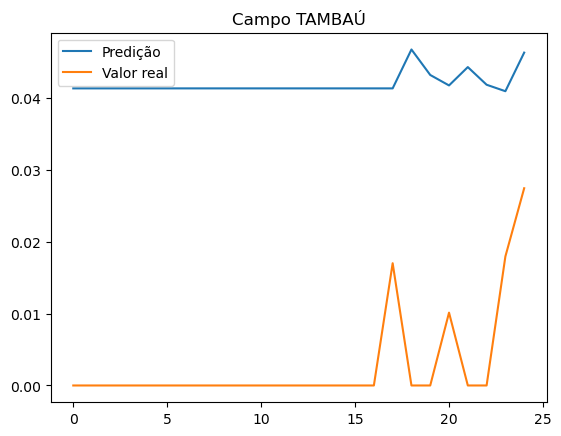

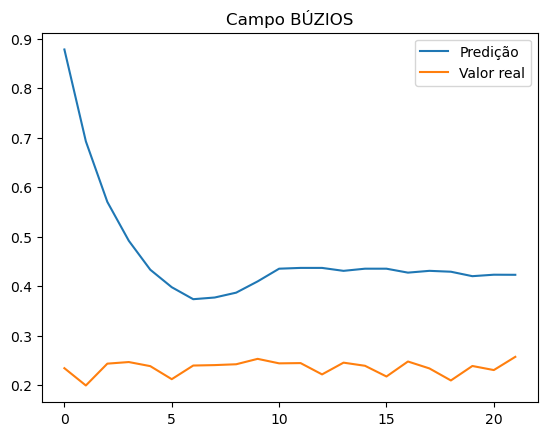

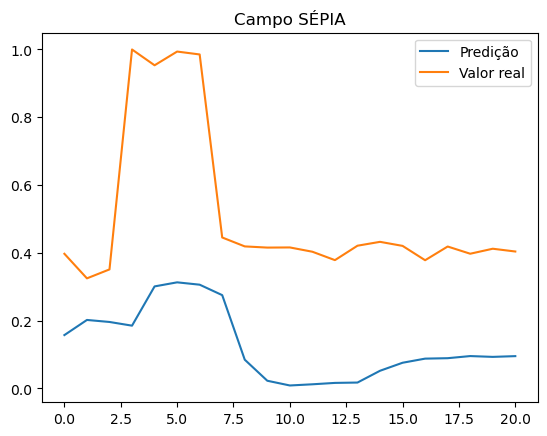

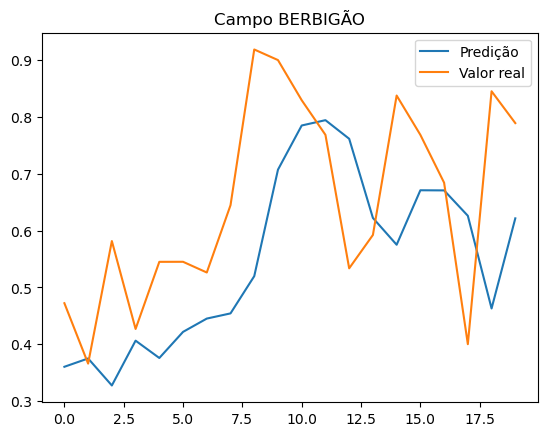

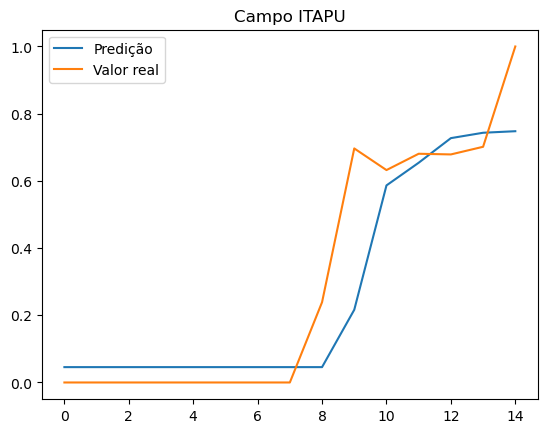

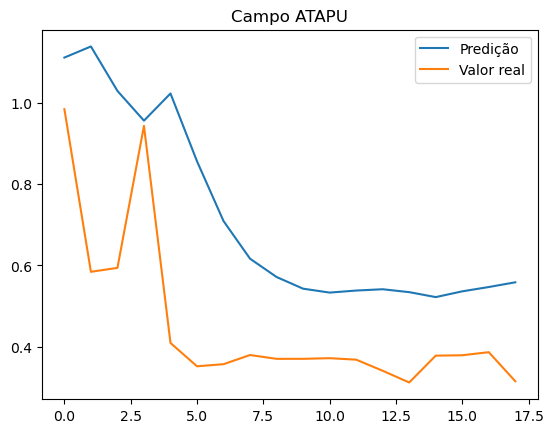

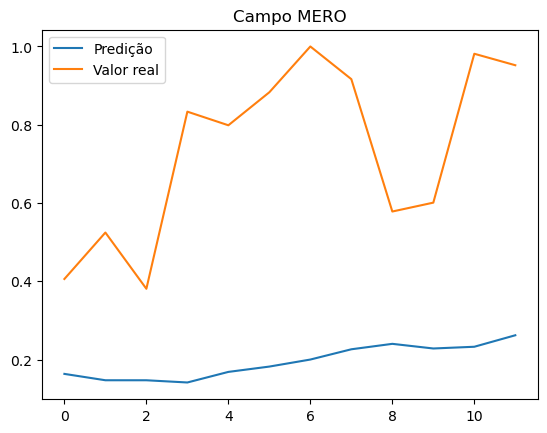

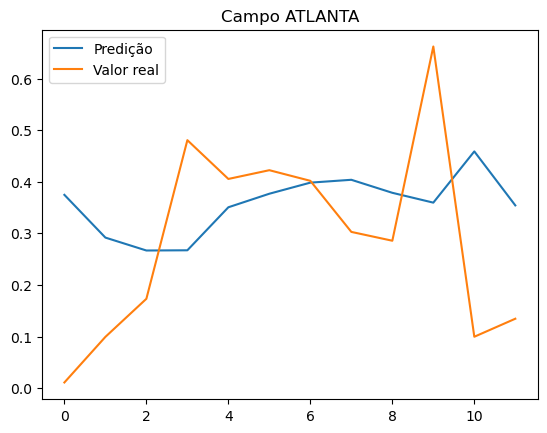

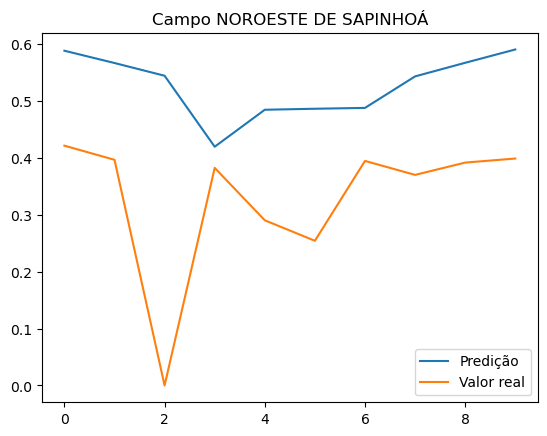

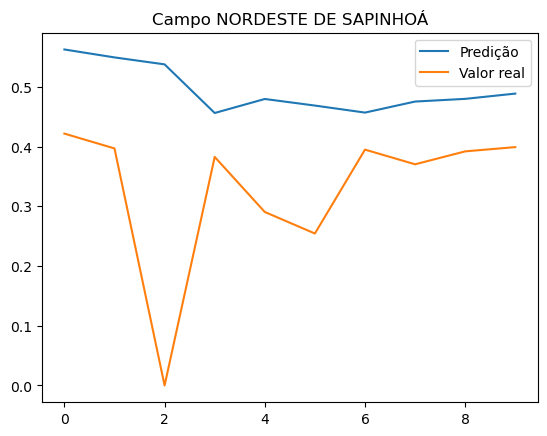

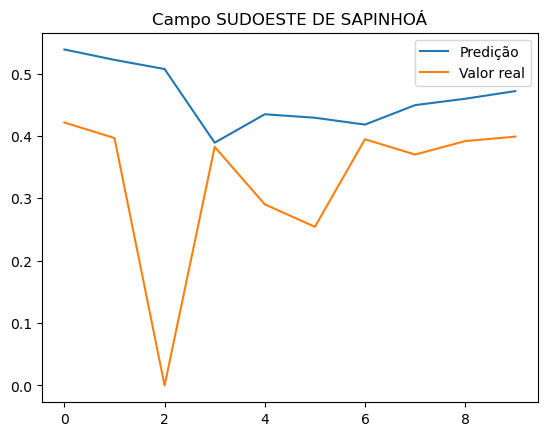

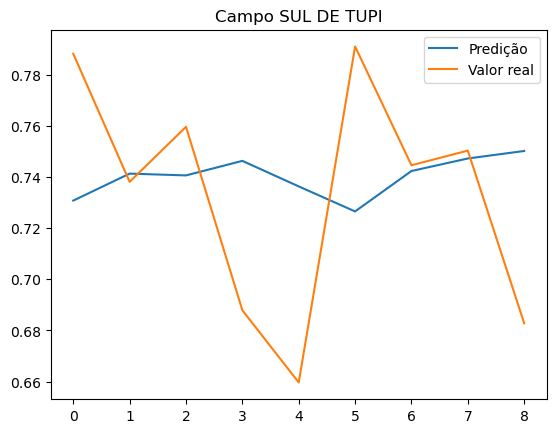

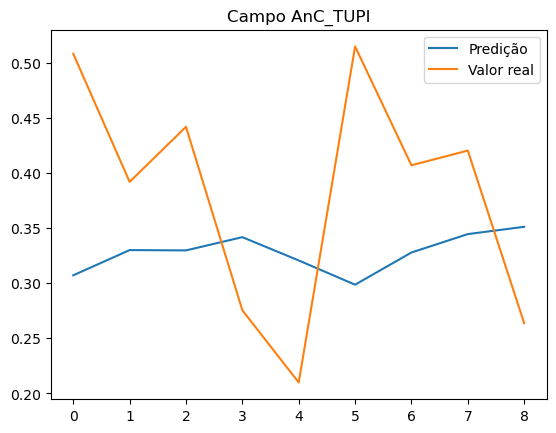

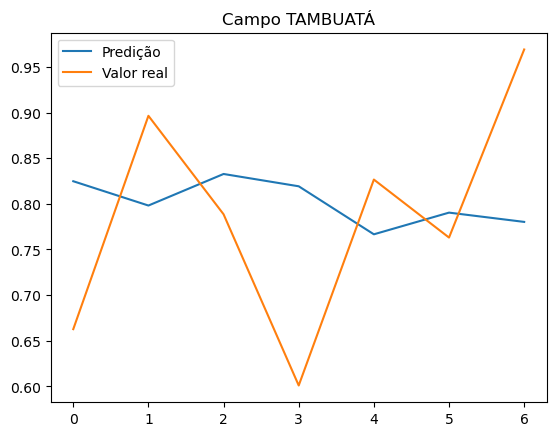

In [12]:
for i in pipe.keys():
    plt.plot(resultados_lstm_individual[resultados_lstm_individual['campo']==i]['preds'].values[0], label='Predição')
    plt.plot(resultados_lstm_individual[resultados_lstm_individual['campo']==i]['y_test'].values[0], label='Valor real')
    plt.legend()
    plt.title('Campo '+str(i) )
    plt.show()

In [13]:
resultados_lstm_individual.to_csv('resultados_lstm_individual.csv' , index = False)

In [236]:
lag = 10
resultados = {
    'campo':[] ,
    #'idx_treino':[] ,
    #'idx_teste': [] ,
    'preds': [] ,
    'y_test':[]
}

campo = 'TUPI'
linhas = pipe[campo][0][10:,np.array(range(9,-1,-1))].shape[0]
X_treino = pipe[campo][0][10:int(linhas * 0.8),np.array(range(9,-1,-1))] 
y_treino = pipe[campo][0][10:int(linhas * 0.8),-1]

for i in list(pipe.keys())[1:]:
    linhas = pipe[campo][0][10:,np.array(range(9,-1,-1))].shape[0]
    X_treino = np.concatenate((X_treino, pipe[campo][0][10:int(linhas * 0.8),np.array(range(9,-1,-1))] ) )
    y_treino = np.concatenate((y_treino,pipe[campo][0][10:int(linhas * 0.8),-1]))

    #X_treino = pipe[campo][0][10:,np.array(range(9,-1,-1))]
    #y_treino = pipe[campo][0][10:,-1]

K.clear_session()

    #tss = TimeSeriesSplit(n_splits = (int)(X_treino.shape[0] * 0.2), test_size = 1)

    #idx_train = range(0,int(X_treino.shape[0] * 0.8))
    #idx_test = range( int(X_treino.shape[0] * 0.8) , X_treino.shape[0])

    #for idx_train, idx_test in tss.split(X_treino):
X_train = X_treino[idx_train].reshape(-1,10,1)
y_train = y_treino[idx_train].reshape(-1,1,1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=24, activation='relu', input_shape=(lag, 1)))
#model.add(LSTM(units=50, activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0)

for campo in pipe.keys():
    linhas = pipe[campo][0][10:,np.array(range(9,-1,-1))].shape[0]
    X_test = pipe[campo][0][int(linhas * 0.8):,np.array(range(9,-1,-1))] 
    y_test = pipe[campo][0][int(linhas * 0.8):,-1].reshape(-1,1,1)
    
    #X_test = X_treino[idx_test]
    #y_test = y_treino[idx_test].reshape(-1,1,1)

    predictions = model.predict(X_test)

    resultados['campo'].append(campo)
    #resultados['idx_treino'].append(idx_train)
    #resultados['idx_teste'].append( idx_test)
    resultados['preds'].append( predictions.reshape(-1) )
    resultados['y_test'].append( y_test.reshape(-1) )

    print(f"Campo: {campo} finalizado!" )


2/2 [==============================] - 0s 0s/step
Campo: TUPI finalizado!
2/2 [==============================] - 0s 16ms/step
Campo: BAÚNA finalizado!
2/2 [==============================] - 0s 16ms/step
Campo: URUGUÁ finalizado!
2/2 [==============================] - 0s 16ms/step
Campo: SAPINHOÁ finalizado!
2/2 [==============================] - 0s 0s/step
Campo: MEXILHÃO finalizado!
1/1 [==============================] - 0s 16ms/step
Campo: LAPA finalizado!
2/2 [==============================] - 0s 0s/step
Campo: TAMBAÚ finalizado!
1/1 [==============================] - 0s 16ms/step
Campo: BÚZIOS finalizado!
1/1 [==============================] - 0s 31ms/step
Campo: SÉPIA finalizado!
1/1 [==============================] - 0s 26ms/step
Campo: BERBIGÃO finalizado!
1/1 [==============================] - 0s 16ms/step
Campo: ITAPU finalizado!
1/1 [==============================] - 0s 16ms/step
Campo: ATAPU finalizado!
1/1 [==============================] - 0s 16ms/step
Campo: MERO finaliza

In [240]:
resultados_lstm_empilhado = pd.DataFrame(resultados)

In [244]:
resultados_lstm_empilhado['mse'] = [ mean_squared_error(i[1]['y_test'], i[1]['preds']) for i in resultados_lstm_empilhado.iterrows()]


In [245]:
resultados_lstm_empilhado

,campo,preds,y_test,mse
0,TUPI,"[0.8334764, 0.86685824, 0.88707155, 0.8862625,...","[1.0, 0.9800634713248145, 0.8487978799108383, ...",0.004218
1,BAÚNA,"[0.19904034, 0.19692981, 0.19294682, 0.190921,...","[0.22943686442660638, 0.21174980078042718, 0.2...",0.005468
2,URUGUÁ,"[0.27106863, 0.26708546, 0.258588, 0.27455264,...","[0.34988791498492167, 0.29962662331874995, 0.4...",0.021345
3,SAPINHOÁ,"[0.7866992, 0.77996707, 0.77275866, 0.7147603,...","[0.8104026812901108, 0.8254223745550073, 0.464...",0.010218
4,MEXILHÃO,"[0.515698, 0.5071967, 0.49670014, 0.48975876, ...","[0.561024245182304, 0.5331676154658561, 0.5495...",0.008658
5,LAPA,"[0.5957411, 0.6394889, 0.6801138, 0.7212677, 0...","[0.854837418328039, 0.8687227056088638, 0.9127...",0.037009
6,TAMBAÚ,"[0.09460857, 0.08707593, 0.08077666, 0.0749271...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.001324
7,BÚZIOS,"[0.8384492, 0.8215476, 0.8020389, 0.80331796, ...","[0.7421939151830711, 0.6412304563215577, 0.836...",0.033848
8,SÉPIA,"[0.010799538, 0.010799538, 0.010799538, 0.0107...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.066...",0.073789
9,BERBIGÃO,"[0.79817045, 0.79331064, 0.765109, 0.7574571, ...","[0.8519420266798067, 0.6886112838517607, 0.717...",0.032673


In [249]:
resultados_lstm_empilhado.to_csv('resultados_lstm_empilhado.csv' , index = False )

---
# Grid Search with CV

In [96]:
# Define your LSTM regression model
def create_lstm_model(units1=50, units2=None, units3=None, activation='relu', optimizer='adam', input_shape=(ws, 1)):
    
    if units2 == None and units3 == None:
        model = Sequential()
        model.add(LSTM(units=units1, activation=activation, input_shape=input_shape))
        model.add(Dense(units=1))  # Output layer for regression
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model
    
    elif units2 != None and units3 == None:
        model = Sequential()
        model.add(LSTM(units=units1, activation=activation, return_sequences=True, input_shape=input_shape))
        model.add(LSTM(units=units2, activation=activation))
        model.add(Dense(units=1))  # Output layer for regression
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model
    
    elif units2 != None and units3 != None:
        model = Sequential()
        model.add(LSTM(units=units1, activation=activation, return_sequences=True, input_shape=input_shape))
        model.add(LSTM(units=units2, activation=activation, return_sequences=True))
        model.add(LSTM(units=units3, activation=activation))
        model.add(Dense(units=1))  # Output layer for regression
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model
    
    elif units2 == None and units3 != None:
        model = Sequential()
        model.add(LSTM(units=1, activation=activation, input_shape=input_shape))
        model.add(Dense(units=1))  # Output layer for regression
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model
    
    else:
        model = Sequential()
        model.add(LSTM(units=1, activation=activation, input_shape=input_shape))
        model.add(Dense(units=1))  # Output layer for regression
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model

In [139]:
#campo = 'TUPI'

resultados_gs = {'campo': [],
                 'params': [],
                 'best_score': [] ,
                 'window_length': [] }
for ws in range(1,11):
    for campo in pipe.keys():
    # Load your dataset or replace it with your data loading code
        X_train, y_train = pipe[campo][0][10:int(pipe[campo][0].shape[0] * 0.8),0:ws] , pipe[campo][0][10:int(pipe[campo][0].shape[0] * 0.8),-1]

        # Reshape the input data for LSTM
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        # X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

        K.clear_session()

        # Define hyperparameters to tune
        param_grid = {

            'units1': [32,64],
            'units2': [32, 64],
            #'units3': [8, 16],
            'optimizer': ['adam', 'rmsprop']
        }

        # Create the LSTM model
        lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))

        # Use TimeSeriesSplit for time-series data
        tscv = TimeSeriesSplit(n_splits=3)

        # Perform grid search with cross-validation
        grid = GridSearchCV(estimator=lstm_model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
        grid_result = grid.fit(X_train, y_train)



        resultados_gs['campo'].append(campo)
        resultados_gs['params'].append( grid_result.best_params_ )
        resultados_gs['best_score'].append( grid_result.best_score_ )
        resultados_gs['window_length'].append( ws )

        print(f"\n\nCampo {campo} executado!\n\n")


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BAÚNA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo URUGUÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo MEXILHÃO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo LAPA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TAMBAÚ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BÚZIOS executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SÉPIA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BERBIGÃO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ITAPU executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ATAPU executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo MERO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ATLANTA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo NOROESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo NORDESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SUDOESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SUL DE TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo AnC_TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TAMBUATÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BAÚNA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo URUGUÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo MEXILHÃO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo LAPA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TAMBAÚ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BÚZIOS executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SÉPIA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BERBIGÃO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ITAPU executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ATAPU executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo MERO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ATLANTA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo NOROESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo NORDESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SUDOESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SUL DE TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo AnC_TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TAMBUATÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BAÚNA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo URUGUÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo MEXILHÃO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo LAPA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TAMBAÚ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BÚZIOS executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SÉPIA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BERBIGÃO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ITAPU executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ATAPU executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo MERO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ATLANTA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo NOROESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo NORDESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SUDOESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SUL DE TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo AnC_TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TAMBUATÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BAÚNA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo URUGUÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo MEXILHÃO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo LAPA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TAMBAÚ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BÚZIOS executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SÉPIA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BERBIGÃO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ITAPU executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ATAPU executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo MERO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ATLANTA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo NOROESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo NORDESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SUDOESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SUL DE TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo AnC_TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TAMBUATÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BAÚNA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo URUGUÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo MEXILHÃO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo LAPA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TAMBAÚ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BÚZIOS executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SÉPIA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BERBIGÃO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ITAPU executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ATAPU executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo MERO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ATLANTA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo NOROESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo NORDESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SUDOESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SUL DE TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo AnC_TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TAMBUATÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BAÚNA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo URUGUÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo MEXILHÃO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo LAPA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TAMBAÚ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BÚZIOS executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SÉPIA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BERBIGÃO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ITAPU executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ATAPU executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo MERO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ATLANTA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo NOROESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo NORDESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SUDOESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SUL DE TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo AnC_TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TAMBUATÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BAÚNA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo URUGUÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo MEXILHÃO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo LAPA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TAMBAÚ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BÚZIOS executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SÉPIA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BERBIGÃO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ITAPU executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ATAPU executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo MERO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ATLANTA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo NOROESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo NORDESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SUDOESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SUL DE TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo AnC_TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TAMBUATÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BAÚNA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo URUGUÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo MEXILHÃO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo LAPA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TAMBAÚ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BÚZIOS executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SÉPIA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BERBIGÃO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ITAPU executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ATAPU executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo MERO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ATLANTA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo NOROESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo NORDESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SUDOESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SUL DE TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo AnC_TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TAMBUATÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BAÚNA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo URUGUÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo MEXILHÃO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo LAPA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TAMBAÚ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BÚZIOS executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SÉPIA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BERBIGÃO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ITAPU executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ATAPU executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo MERO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ATLANTA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo NOROESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo NORDESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SUDOESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SUL DE TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo AnC_TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TAMBUATÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BAÚNA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo URUGUÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo MEXILHÃO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo LAPA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TAMBAÚ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BÚZIOS executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SÉPIA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo BERBIGÃO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ITAPU executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ATAPU executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo MERO executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo ATLANTA executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo NOROESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo NORDESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SUDOESTE DE SAPINHOÁ executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo SUL DE TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo AnC_TUPI executado!


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\herli\AppData\Local\Temp\ipykernel_22112\1221214831.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0, input_shape=(ws,1))




Campo TAMBUATÁ executado!




In [140]:
pd.DataFrame(resultados_gs)

,campo,params,best_score,window_length
0,TUPI,"{'optimizer': 'rmsprop', 'units1': 64, 'units2...",-0.248671,1
1,BAÚNA,"{'optimizer': 'rmsprop', 'units1': 64, 'units2...",-0.270513,1
2,URUGUÁ,"{'optimizer': 'rmsprop', 'units1': 64, 'units2...",-0.287959,1
3,SAPINHOÁ,"{'optimizer': 'rmsprop', 'units1': 64, 'units2...",-0.521070,1
4,MEXILHÃO,"{'optimizer': 'rmsprop', 'units1': 64, 'units2...",-0.416845,1
...,...,...,...,...
195,NORDESTE DE SAPINHOÁ,"{'optimizer': 'rmsprop', 'units1': 64, 'units2...",-0.066439,10
196,SUDOESTE DE SAPINHOÁ,"{'optimizer': 'rmsprop', 'units1': 32, 'units2...",-0.063098,10
197,SUL DE TUPI,"{'optimizer': 'rmsprop', 'units1': 64, 'units2...",-0.007402,10
198,AnC_TUPI,"{'optimizer': 'rmsprop', 'units1': 32, 'units2...",-0.026609,10


In [141]:
resultados_gs_lstm = pd.DataFrame(resultados_gs)

In [114]:
resultados_gs_lstm.to_csv('resultados_grid_search_lstm.csv' , index=False)

In [142]:
resultados_gs_lstm.sort_values(by='best_score',ascending=False).groupby('campo').first().reset_index()

,campo,params,best_score,window_length
0,ATAPU,"{'optimizer': 'adam', 'units1': 32, 'units2': 32}",-0.100551,5
1,ATLANTA,"{'optimizer': 'rmsprop', 'units1': 64, 'units2...",-0.040180,7
2,AnC_TUPI,"{'optimizer': 'rmsprop', 'units1': 32, 'units2...",-0.026609,10
3,BAÚNA,"{'optimizer': 'rmsprop', 'units1': 64, 'units2...",-0.033632,8
4,BERBIGÃO,"{'optimizer': 'rmsprop', 'units1': 64, 'units2...",-0.081104,7
5,BÚZIOS,"{'optimizer': 'rmsprop', 'units1': 64, 'units2...",-0.027226,7
6,ITAPU,"{'optimizer': 'adam', 'units1': 64, 'units2': 32}",-0.000435,1
7,LAPA,"{'optimizer': 'rmsprop', 'units1': 64, 'units2...",-0.031042,9
8,MERO,"{'optimizer': 'rmsprop', 'units1': 64, 'units2...",-0.004611,4
9,MEXILHÃO,"{'optimizer': 'rmsprop', 'units1': 64, 'units2...",-0.018443,8


In [146]:
resultados_gs_lstm2 = resultados_gs_lstm.sort_values(by='best_score',ascending=False).groupby('campo').first().reset_index()

In [147]:
resultados_gs_lstm2.to_csv('resultados_grid_search_lstm2.csv' , index=False)

In [148]:
# Print the best parameters and corresponding MSE
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

Best: -0.03411044362256994 using {'optimizer': 'rmsprop', 'units1': 64, 'units2': 64}


In [70]:
# Get the best model and predict on validation set
best_lstm_model = grid_result.best_estimator_.model

In [73]:
grid_result.best_params_

{'optimizer': 'rmsprop', 'units1': 32, 'units2': 64, 'units3': None}

---
# Fitting the models with hyperparameters found in grid search

In [128]:
resultados_gs_lstm2[resultados_gs_lstm2['campo'] == campo ]['window_length'].iloc[0]

10

In [126]:
resultados_gs_lstm2[resultados_gs_lstm2['campo'] == campo ]['params'].iloc[0]['units1']

16

In [ ]:
create_lstm_model(

In [164]:
#lag = 10
resultados = {
    'campo':[] ,
    'idx_treino':[] ,
    'idx_teste': [] ,
    'preds': [] ,
    'y_test':[]
}

for campo in pipe.keys():
    #campo = 'TUPI'

    wl = resultados_gs_lstm2[resultados_gs_lstm2['campo'] == campo ]['window_length'].iloc[0]

    X_treino = pipe[campo][0][10:,0:wl]
    y_treino = pipe[campo][0][10:,-1]

    K.clear_session()

    tss = TimeSeriesSplit(n_splits = (int)(X_treino.shape[0] * 0.2), test_size = 1)

    for idx_train, idx_test in tss.split(X_treino):
        X_train = X_treino[idx_train].reshape(-1,X_treino.shape[1],1)
        y_train = y_treino[idx_train].reshape(-1,1,1)

        #idx_campo = resultados_gs['campo'].index(campo)


        # Build the LSTM model
        model = create_lstm_model( units1 = resultados_gs_lstm2[resultados_gs_lstm2['campo'] == campo ]['params'].iloc[0]['units1'] ,
                                  units2 = resultados_gs_lstm2[resultados_gs_lstm2['campo'] == campo ]['params'].iloc[0]['units2'] ,
                                  #units3 = resultados_gs['params'][idx_campo]['units3'] , 
                                  optimizer = resultados_gs_lstm2[resultados_gs_lstm2['campo'] == campo ]['params'].iloc[0]['optimizer'],
                                  input_shape=(wl, 1)
                                 )

        #print( model.summary() )
        X_test = X_treino[idx_test].reshape(-1,X_treino.shape[1],1)
        y_test = y_treino[idx_test].reshape(-1,1,1)
        # Train the model
        history = model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0, validation_data=(X_test, y_test))

        predictions = model.predict(X_test)

        resultados['campo'].append(campo)
        resultados['idx_treino'].append(idx_train)
        resultados['idx_teste'].append( idx_test)
        resultados['preds'].append( predictions.reshape(-1)[0] )
        resultados['y_test'].append( y_test.reshape(-1)[0] )

        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Test Loss')
        #plt.title('Training and Test Loss over Epochs')
        #plt.xlabel('Epoch')
        #plt.ylabel('Loss')
        #plt.legend()
        #plt.show()

    print(f"Campo: {campo} finalizado!" )

1/1 [==============================] - 0s 157ms/step
Campo: TUPI finalizado!
1/1 [==============================] - 0s 188ms/step
Campo: BAÚNA finalizado!
1/1 [==============================] - 0s 173ms/step
Campo: URUGUÁ finalizado!
1/1 [==============================] - 0s 173ms/step
Campo: SAPINHOÁ finalizado!
1/1 [==============================] - 0s 172ms/step
Campo: MEXILHÃO finalizado!
1/1 [==============================] - 0s 236ms/step
Campo: LAPA finalizado!
1/1 [==============================] - 0s 188ms/step
Campo: TAMBAÚ finalizado!
1/1 [==============================] - 0s 188ms/step
Campo: BÚZIOS finalizado!
1/1 [==============================] - 0s 173ms/step
Campo: SÉPIA finalizado!
1/1 [==============================] - 0s 172ms/step
Campo: BERBIGÃO finalizado!
1/1 [==============================] - 0s 157ms/step
Campo: ITAPU finalizado!
1/1 [==============================] - 0s 172ms/step
Campo: ATAPU finalizado!
1/1 [==============================] - 0s 173ms/step
C

In [17]:
resultados_lstm = pd.DataFrame(resultados)

In [18]:
resultados_lstm.to_csv('resultados_lstm.csv' , index= False )

<Axes: >

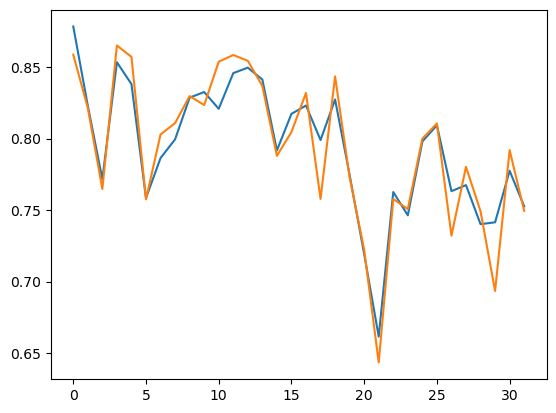

In [19]:
resultados_lstm[resultados_lstm['campo']=='TUPI']['preds'].plot()
resultados_lstm[resultados_lstm['campo']=='TUPI']['y_test'].plot()

In [20]:
mean_squared_error( np.array(resultados['y_test']) , np.array(resultados['preds']) , squared = False)

0.05357493944402015

---
# Calculating evaluation metrics

In [21]:
results = pd.read_csv('resultados_lstm.csv')

In [22]:
mean_squared_error( results['y_test'] , results['preds'] , squared = False)

0.0535749401716454

In [23]:
mean_absolute_error(  results['y_test'] , results['preds'] )

0.026858998703756076

In [24]:
mean_absolute_percentage_error ( results['y_test'] , results['preds'])

10167394296887.812

In [25]:
calculate_smape(results['y_test'] , results['preds'])

33.96